BƯỚC 4: PHÂN TÍCH CHUỖI HÀNH VI - MARKOV CHAINS & N-GRAMS

📂 4.1: Load event logs và clustered user data...
✅ Loaded 5000 events from 1090 users
✅ Event types: ['resource_view', 'quiz_attempt', 'assignment_submit', 'reading_complete', 'video_view', 'forum_post']

Archetype distribution in events:
archetype
Struggling but Trying    2084
Efficient Learner        1009
Name: count, dtype: int64

4.2: TẠO EVENT SEQUENCES CHO MỖI USER

✅ Created sequences for 1090 users

Example sequences (first 3 users):
   User 9000: ['resource_view', 'quiz_attempt', 'reading_complete', 'video_view', 'video_view', 'video_view', 'reading_complete', 'forum_post']... (len=8)
   User 9001: ['quiz_attempt', 'resource_view', 'video_view', 'assignment_submit', 'assignment_submit']... (len=5)
   User 9002: ['quiz_attempt', 'quiz_attempt', 'quiz_attempt', 'quiz_attempt', 'quiz_attempt']... (len=5)

📊 Sequence Length Statistics:
   • Mean: 4.59
   • Median: 4.00
   • Min-Max: [1, 12]

4.3: XÂY DỰNG MARKOV CHAIN (GLO

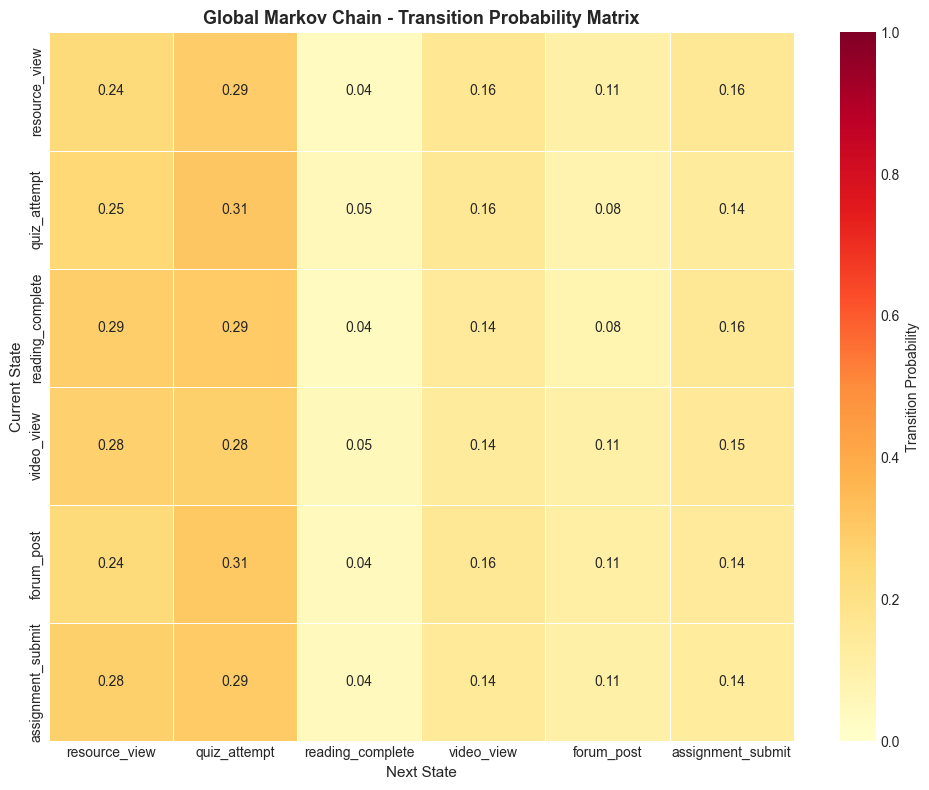

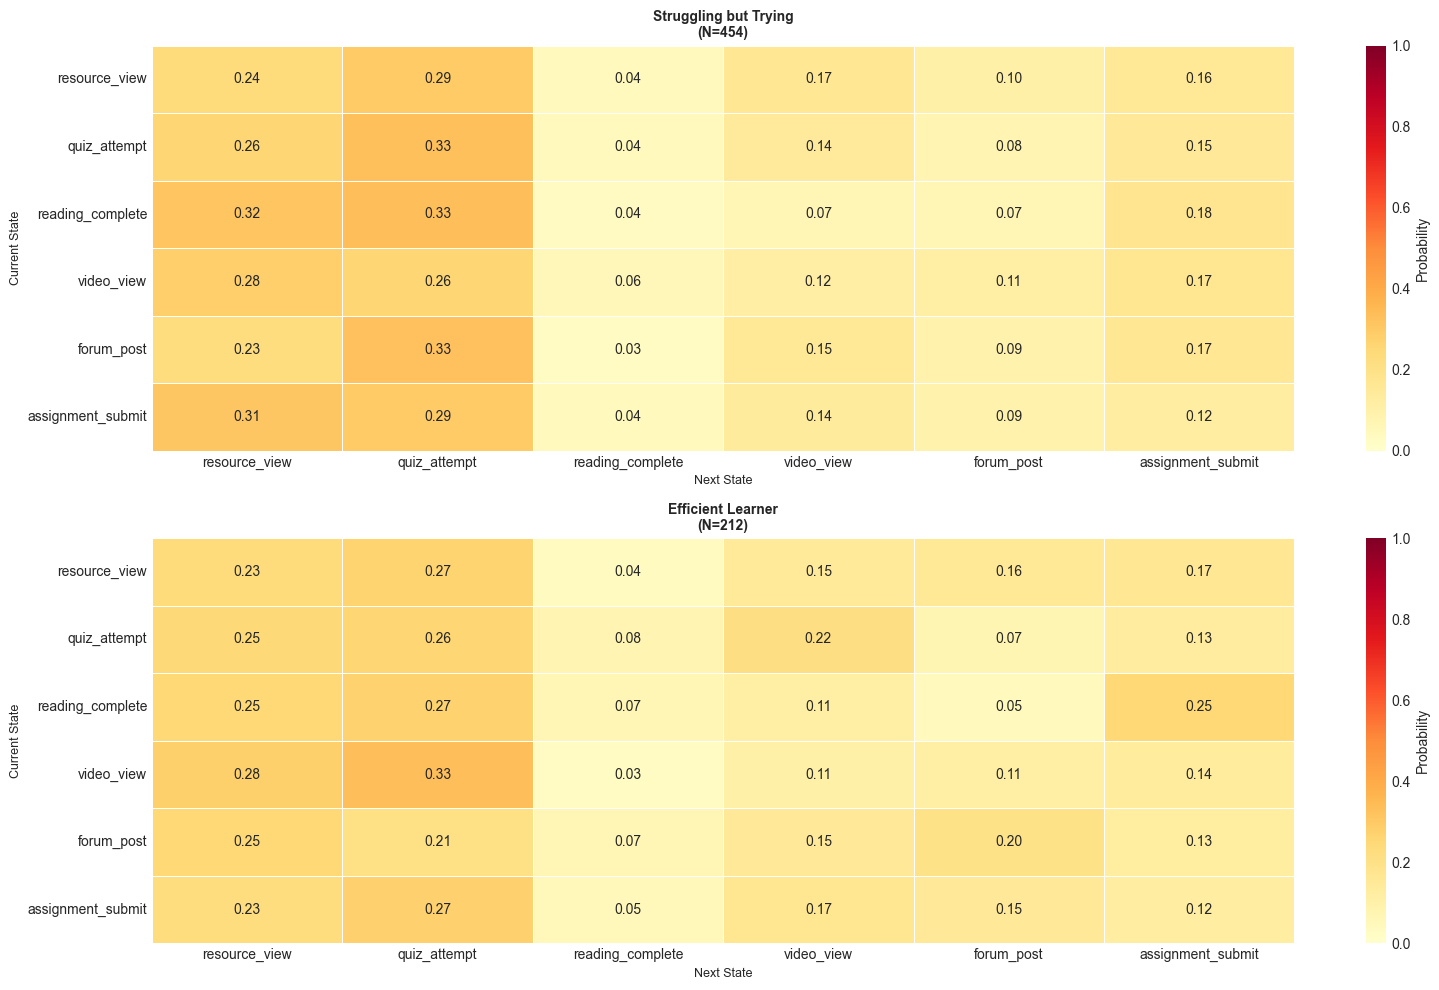

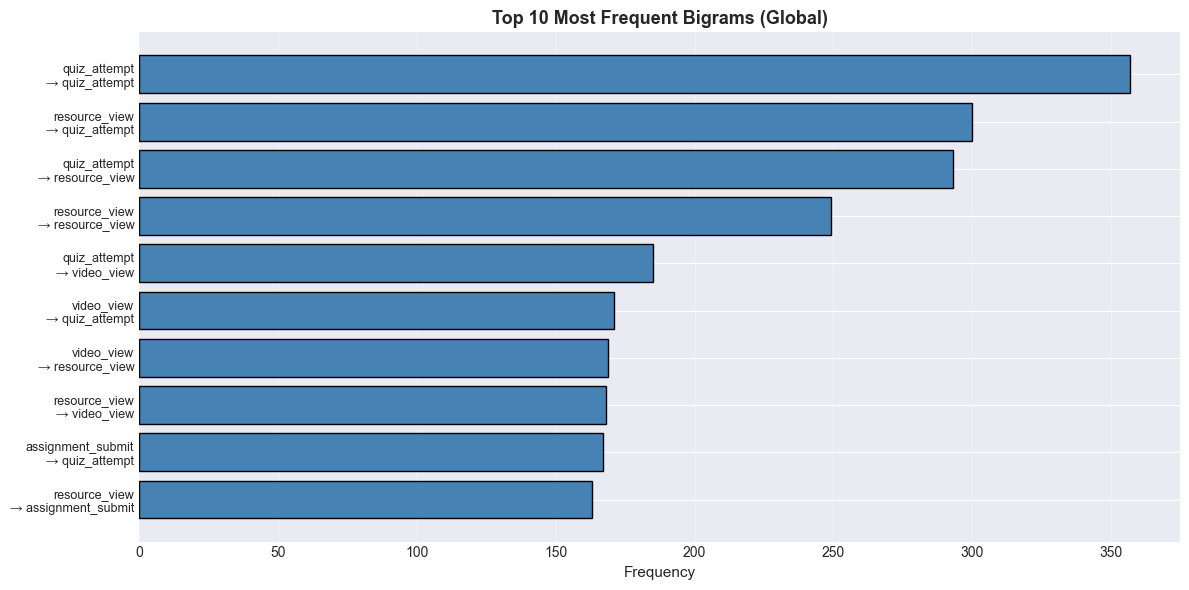

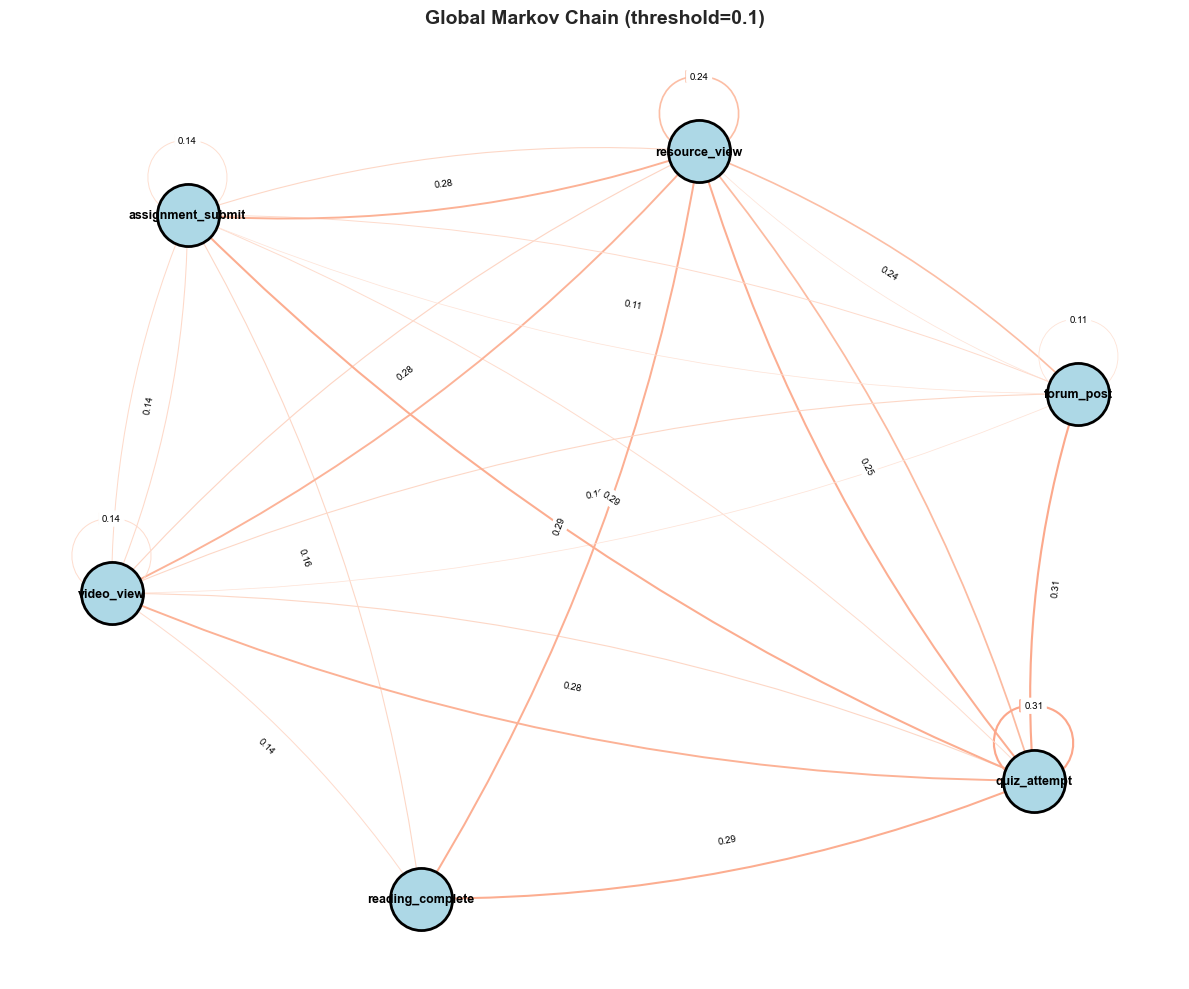

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import networkx as nx
import json
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# BƯỚC 4: BEHAVIORAL SEQUENCE ANALYSIS (MARKOV CHAINS & N-GRAMS)
# ============================================================================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("BƯỚC 4: PHÂN TÍCH CHUỖI HÀNH VI - MARKOV CHAINS & N-GRAMS")
print("="*80)

# ----------------------------------------------------------------------------
# 4.1: LOAD DỮ LIỆU TỪ BƯỚC 1 VÀ BƯỚC 3
# ----------------------------------------------------------------------------
print("\n📂 4.1: Load event logs và clustered user data...")

# Load event logs (từ Bước 1)
# NOTE: Bạn cần có file event logs gốc với columns: userid, timecreated, eventname
# Đây là demo với synthetic data
np.random.seed(42)
event_types = ['quiz_attempt', 'resource_view', 'forum_post', 'assignment_submit', 
               'video_view', 'reading_complete']

# Generate synthetic event logs
n_events = 5000
df_events = pd.DataFrame({
    'userid': np.random.randint(9000, 10100, n_events),
    'timecreated': np.sort(np.random.randint(1674000000, 1675000000, n_events)),
    'eventname': np.random.choice(event_types, n_events, 
                                 p=[0.3, 0.25, 0.1, 0.15, 0.15, 0.05])
})


# Load clustered users (từ Bước 3)
df_users = pd.read_csv('../step3_kmean_cluster/user_features_clustered.csv')

# Merge để có archetype cho mỗi event
df_events = df_events.merge(df_users[['userid', 'cluster', 'archetype']], 
                            on='userid', how='left')

print(f"✅ Loaded {len(df_events)} events from {df_events['userid'].nunique()} users")
print(f"✅ Event types: {df_events['eventname'].unique().tolist()}")
print(f"\nArchetype distribution in events:")
print(df_events['archetype'].value_counts())

# ----------------------------------------------------------------------------
# 4.2: CREATE EVENT SEQUENCES PER USER
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4.2: TẠO EVENT SEQUENCES CHO MỖI USER")
print("="*80)

# Sort by user and time
df_events = df_events.sort_values(['userid', 'timecreated'])

# Create sequences (list of events per user)
user_sequences = df_events.groupby('userid')['eventname'].apply(list).to_dict()

print(f"\n✅ Created sequences for {len(user_sequences)} users")
print(f"\nExample sequences (first 3 users):")
for i, (user, seq) in enumerate(list(user_sequences.items())[:3]):
    print(f"   User {user}: {seq[:10]}... (len={len(seq)})")

# Sequence length statistics
seq_lengths = [len(seq) for seq in user_sequences.values()]
print(f"\n📊 Sequence Length Statistics:")
print(f"   • Mean: {np.mean(seq_lengths):.2f}")
print(f"   • Median: {np.median(seq_lengths):.2f}")
print(f"   • Min-Max: [{np.min(seq_lengths)}, {np.max(seq_lengths)}]")

# ----------------------------------------------------------------------------
# 4.3: BUILD MARKOV CHAINS (GLOBAL)
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4.3: XÂY DỰNG MARKOV CHAIN (GLOBAL - TẤT CẢ USERS)")
print("="*80)

def build_transition_matrix(sequences, states):
    """
    Build first-order Markov chain transition matrix
    P(state_t+1 | state_t)
    """
    n_states = len(states)
    state_to_idx = {state: idx for idx, state in enumerate(states)}
    
    # Initialize transition count matrix
    transition_counts = np.zeros((n_states, n_states))
    
    # Count transitions
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            current_state = sequence[i]
            next_state = sequence[i + 1]
            if current_state in state_to_idx and next_state in state_to_idx:
                current_idx = state_to_idx[current_state]
                next_idx = state_to_idx[next_state]
                transition_counts[current_idx, next_idx] += 1
    
    # Convert to probabilities (normalize rows)
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        row_sum = transition_counts[i].sum()
        if row_sum > 0:
            transition_matrix[i] = transition_counts[i] / row_sum
    
    return transition_matrix, transition_counts, state_to_idx

# Get all unique states
all_states = df_events['eventname'].unique().tolist()
print(f"📋 States (event types): {all_states}")

# Build global transition matrix
transition_matrix_global, transition_counts_global, state_to_idx = \
    build_transition_matrix(user_sequences.values(), all_states)

print(f"\n✅ Built global Markov chain")
print(f"\nTransition Matrix (rows=current state, cols=next state):")
df_transition = pd.DataFrame(transition_matrix_global, 
                             index=all_states, 
                             columns=all_states)
print(df_transition.round(3))

# Visualization: Transition matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_transition, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Transition Probability'}, 
            linewidths=0.5, vmin=0, vmax=1)
plt.title('Global Markov Chain - Transition Probability Matrix', 
          fontweight='bold', fontsize=13)
plt.xlabel('Next State', fontsize=11)
plt.ylabel('Current State', fontsize=11)
plt.tight_layout()
plt.savefig('step4_global_transition_matrix.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: step4_global_transition_matrix.png")

# ----------------------------------------------------------------------------
# 4.4: BUILD ARCHETYPE-SPECIFIC MARKOV CHAINS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4.4: XÂY DỰNG MARKOV CHAINS CHO TỪNG ARCHETYPE")
print("="*80)

# Group sequences by archetype
archetype_sequences = defaultdict(list)
for idx, row in df_events.iterrows():
    archetype = row['archetype']
    if pd.notna(archetype):
        archetype_sequences[archetype].append(row['eventname'])

# Convert to user-level sequences per archetype
archetype_user_sequences = {}
for archetype in df_events['archetype'].dropna().unique():
    users_in_archetype = df_users[df_users['archetype'] == archetype]['userid'].tolist()
    archetype_user_sequences[archetype] = [
        user_sequences[user] for user in users_in_archetype if user in user_sequences
    ]

# Build transition matrix for each archetype
archetype_transitions = {}
for archetype, sequences in archetype_user_sequences.items():
    if len(sequences) > 0:
        trans_matrix, trans_counts, _ = build_transition_matrix(sequences, all_states)
        archetype_transitions[archetype] = {
            'matrix': trans_matrix,
            'counts': trans_counts,
            'num_sequences': len(sequences)
        }
        print(f"\n📊 {archetype}:")
        print(f"   • Number of users: {len(sequences)}")
        print(f"   • Transition matrix shape: {trans_matrix.shape}")

# Visualize archetype-specific transitions (heatmaps)
n_archetypes = len(archetype_transitions)
fig, axes = plt.subplots(2, (n_archetypes + 1) // 2, figsize=(16, 10))
axes = axes.flatten() if n_archetypes > 1 else [axes]

for idx, (archetype, data) in enumerate(archetype_transitions.items()):
    df_arch = pd.DataFrame(data['matrix'], index=all_states, columns=all_states)
    sns.heatmap(df_arch, annot=True, fmt='.2f', cmap='YlOrRd', 
                ax=axes[idx], cbar_kws={'label': 'Probability'},
                linewidths=0.5, vmin=0, vmax=1)
    axes[idx].set_title(f'{archetype}\n(N={data["num_sequences"]})', 
                       fontweight='bold', fontsize=10)
    axes[idx].set_xlabel('Next State', fontsize=9)
    axes[idx].set_ylabel('Current State', fontsize=9)

# Hide unused subplots
for idx in range(n_archetypes, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('step4_archetype_transition_matrices.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: step4_archetype_transition_matrices.png")

# ----------------------------------------------------------------------------
# 4.5: N-GRAM ANALYSIS (BIGRAMS & TRIGRAMS)
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4.5: N-GRAM ANALYSIS (FREQUENT PATTERNS)")
print("="*80)

def extract_ngrams(sequences, n=2):
    """Extract n-grams from sequences"""
    ngrams = []
    for seq in sequences:
        for i in range(len(seq) - n + 1):
            ngram = tuple(seq[i:i+n])
            ngrams.append(ngram)
    return Counter(ngrams)

# Bigrams (pairs of consecutive events)
print("\n🔍 BIGRAM ANALYSIS (2-event sequences):")
bigrams_global = extract_ngrams(user_sequences.values(), n=2)
top_bigrams = bigrams_global.most_common(10)

print("\nTop 10 Most Frequent Bigrams:")
for bigram, count in top_bigrams:
    print(f"   {bigram[0]:20s} → {bigram[1]:20s}: {count:4d} times")

# Trigrams (triplets of consecutive events)
print("\n🔍 TRIGRAM ANALYSIS (3-event sequences):")
trigrams_global = extract_ngrams(user_sequences.values(), n=3)
top_trigrams = trigrams_global.most_common(10)

print("\nTop 10 Most Frequent Trigrams:")
for trigram, count in top_trigrams:
    print(f"   {trigram[0]:20s} → {trigram[1]:20s} → {trigram[2]:20s}: {count:3d} times")

# Bigrams per archetype
print("\n🔍 BIGRAMS PER ARCHETYPE:")
archetype_bigrams = {}
for archetype, sequences in archetype_user_sequences.items():
    bigrams = extract_ngrams(sequences, n=2)
    archetype_bigrams[archetype] = bigrams
    top_5 = bigrams.most_common(5)
    print(f"\n📌 {archetype} - Top 5 Bigrams:")
    for bigram, count in top_5:
        print(f"   {bigram[0]:20s} → {bigram[1]:20s}: {count:3d}")

# Visualization: Top bigrams bar chart
plt.figure(figsize=(12, 6))
bigram_labels = [f"{b[0]}\n→ {b[1]}" for b, _ in top_bigrams[:10]]
bigram_counts = [count for _, count in top_bigrams[:10]]

plt.barh(range(len(bigram_labels)), bigram_counts, color='steelblue', edgecolor='black')
plt.yticks(range(len(bigram_labels)), bigram_labels, fontsize=9)
plt.xlabel('Frequency', fontsize=11)
plt.title('Top 10 Most Frequent Bigrams (Global)', fontweight='bold', fontsize=13)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('step4_top_bigrams.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: step4_top_bigrams.png")

# ----------------------------------------------------------------------------
# 4.6: MARKOV CHAIN GRAPH VISUALIZATION
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4.6: VISUALIZATION - MARKOV CHAIN AS DIRECTED GRAPH")
print("="*80)

def visualize_markov_chain(transition_matrix, states, title, threshold=0.1):
    """
    Visualize Markov chain as directed graph
    Only show edges with probability > threshold
    """
    G = nx.DiGraph()
    
    # Add nodes
    G.add_nodes_from(states)
    
    # Add edges (only if probability > threshold)
    for i, current_state in enumerate(states):
        for j, next_state in enumerate(states):
            prob = transition_matrix[i, j]
            if prob > threshold:
                G.add_edge(current_state, next_state, weight=prob)
    
    # Layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Draw
    plt.figure(figsize=(12, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', 
                          edgecolors='black', linewidths=2)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    
    # Draw edges with varying thickness based on probability
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    nx.draw_networkx_edges(G, pos, width=[w*5 for w in weights], 
                          edge_color=weights, edge_cmap=plt.cm.Reds,
                          edge_vmin=0, edge_vmax=1,
                          arrows=True, arrowsize=20, arrowstyle='-|>',
                          connectionstyle='arc3,rad=0.1')
    
    # Draw edge labels (probabilities)
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)
    
    plt.title(title, fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.tight_layout()

# Visualize global Markov chain
visualize_markov_chain(transition_matrix_global, all_states, 
                      'Global Markov Chain (threshold=0.1)', threshold=0.1)
plt.savefig('step4_markov_chain_graph.png', dpi=150, bbox_inches='tight')
print("✅ Saved: step4_markov_chain_graph.png")

# ----------------------------------------------------------------------------
# 4.7: SEQUENTIAL PATTERN MINING (OPTIONAL ADVANCED)
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4.7: SEQUENTIAL PATTERN MINING")
print("="*80)

def find_frequent_subsequences(sequences, min_support=0.05):
    """
    Find frequent subsequences (simple implementation)
    min_support: minimum percentage of sequences that must contain the pattern
    """
    # Generate candidate patterns (length 2-4)
    all_patterns = []
    
    for seq in sequences:
        # Extract all subsequences of length 2-4
        for length in range(2, min(5, len(seq) + 1)):
            for i in range(len(seq) - length + 1):
                pattern = tuple(seq[i:i+length])
                all_patterns.append(pattern)
    
    # Count pattern frequencies
    pattern_counts = Counter(all_patterns)
    total_sequences = len(sequences)
    
    # Filter by min_support
    frequent_patterns = {
        pattern: count 
        for pattern, count in pattern_counts.items() 
        if count / total_sequences >= min_support
    }
    
    return frequent_patterns

frequent_patterns = find_frequent_subsequences(list(user_sequences.values()), 
                                              min_support=0.05)

print(f"\n📋 Found {len(frequent_patterns)} frequent patterns (support ≥ 5%)")
print("\nTop 15 Frequent Sequential Patterns:")

# Sort by frequency
sorted_patterns = sorted(frequent_patterns.items(), key=lambda x: x[1], reverse=True)[:15]
for pattern, count in sorted_patterns:
    support = count / len(user_sequences) * 100
    pattern_str = " → ".join(pattern)
    print(f"   {pattern_str:60s} : {count:3d} ({support:.1f}%)")

# ----------------------------------------------------------------------------
# 4.8: SAVE OUTPUT CHO BƯỚC 5 (SIMULATION)
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4.8: SAVE TRANSITION MODELS CHO BƯỚC 5 (SIMULATION)")
print("="*80)

# Prepare output data structure
markov_models = {
    'states': all_states,
    'global': {
        'transition_matrix': transition_matrix_global.tolist(),
        'transition_counts': transition_counts_global.tolist()
    },
    'archetypes': {}
}

# Add archetype-specific models
for archetype, data in archetype_transitions.items():
    markov_models['archetypes'][archetype] = {
        'transition_matrix': data['matrix'].tolist(),
        'transition_counts': data['counts'].tolist(),
        'num_sequences': int(data['num_sequences'])
    }

# Save Markov models
with open('markov_models_step4.json', 'w') as f:
    json.dump(markov_models, f, indent=2)

# Save n-grams
ngram_data = {
    'bigrams': {
        'global': {str(k): v for k, v in bigrams_global.most_common(50)},
        'by_archetype': {
            archetype: {str(k): v for k, v in bigrams.most_common(20)}
            for archetype, bigrams in archetype_bigrams.items()
        }
    },
    'trigrams': {
        'global': {str(k): v for k, v in trigrams_global.most_common(50)}
    },
    'frequent_patterns': {
        str(k): v for k, v in sorted_patterns[:50]
    }
}

with open('ngram_patterns_step4.json', 'w') as f:
    json.dump(ngram_data, f, indent=2)

# Save sequence statistics
sequence_stats = {
    'total_users': len(user_sequences),
    'total_events': len(df_events),
    'avg_sequence_length': float(np.mean(seq_lengths)),
    'median_sequence_length': float(np.median(seq_lengths)),
    'min_sequence_length': int(np.min(seq_lengths)),
    'max_sequence_length': int(np.max(seq_lengths)),
    'event_type_distribution': df_events['eventname'].value_counts().to_dict()
}

with open('sequence_statistics_step4.json', 'w') as f:
    json.dump(sequence_stats, f, indent=2)

print("✅ Saved: markov_models_step4.json")
print("✅ Saved: ngram_patterns_step4.json")
print("✅ Saved: sequence_statistics_step4.json")

# ----------------------------------------------------------------------------
# 4.9: KẾT LUẬN VÀ NEXT STEPS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("🎯 BƯỚC 4 HOÀN THÀNH - KẾT LUẬN")
print("="*80)

print(f"""
✅ ĐÃ HOÀN THÀNH:
   1. ✓ Tạo event sequences cho {len(user_sequences)} users
   2. ✓ Xây dựng global Markov chain (first-order)
   3. ✓ Xây dựng archetype-specific Markov chains
   4. ✓ N-gram analysis (bigrams, trigrams)
   5. ✓ Sequential pattern mining
   6. ✓ Markov chain graph visualization

📂 OUTPUT FILES:
   • markov_models_step4.json - Transition matrices (DÙNG CHO BƯỚC 5)
   • ngram_patterns_step4.json - N-gram frequencies
   • sequence_statistics_step4.json - Sequence stats
   • step4_global_transition_matrix.png - Heatmap
   • step4_archetype_transition_matrices.png - Per-archetype heatmaps
   • step4_top_bigrams.png - Bar chart
   • step4_markov_chain_graph.png - Network visualization

📊 SEQUENCE ANALYSIS SUMMARY:
   • Total sequences: {len(user_sequences)}
   • Avg sequence length: {np.mean(seq_lengths):.1f} events
   • Total event types: {len(all_states)}
   • Archetypes analyzed: {len(archetype_transitions)}
   • Top bigram: {top_bigrams[0][0]} ({top_bigrams[0][1]} times)
   • Top trigram: {top_trigrams[0][0]} ({top_trigrams[0][1]} times)

🔍 KEY INSIGHTS (Example interpretation):
   • High transition probability quiz → video suggests students watch videos after quiz attempts
   • Different archetypes show different behavioral patterns
   • Frequent patterns can guide content recommendation strategies

🔜 NEXT STEPS (BƯỚC 5 - STUDENT AGENT SIMULATION):
   → Dùng file: markov_models_step4.json
   → Implement Agent-Based Model (ABM)
   → Mỗi agent (student) thuộc 1 archetype
   → Use Markov transition probabilities để generate realistic event sequences
   → Simulate performance outcomes based on behavioral patterns

💡 LIÊN KẾT VỚI Q-LEARNING:
   • Transition probabilities → giúp thiết kế STATE TRANSITIONS trong MDP
   • Sequential patterns → define REWARD based on event sequences
     Ví dụ: Reward cao nếu sequence leads to quiz improvement
   • Archetype-specific behaviors → personalized Q-tables
   • Frequent patterns → identify "successful learning paths" to reinforce
""")

plt.show()